In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=1)

In [4]:
import glob
import numpy as np
from PIL import Image
from utils.data import sample_indices
import random

def load_shapes_dataset(dirpath='data/shapes'):
    x = []
    y = []

    label_dict = {
        'circles'   : 0,
        'squares'   : 1,
        'triangles' : 2
    }

    files = glob.glob(dirpath + '/**/*.png', recursive=True)

    for f in files:
        img=Image.open(f)
        img=img.resize(size=(28,28))
        img=img.convert('L')
        x.append(np.array(img))
        label = f.split('/')[-2]
        #y.append(label_dict[label])
        y.append(label)
        del img

    return np.array(x), np.array(y)

torch.Size([8000, 1, 28, 28]) torch.Size([2000, 1, 28, 28])
tensor(0.) tensor(1.)


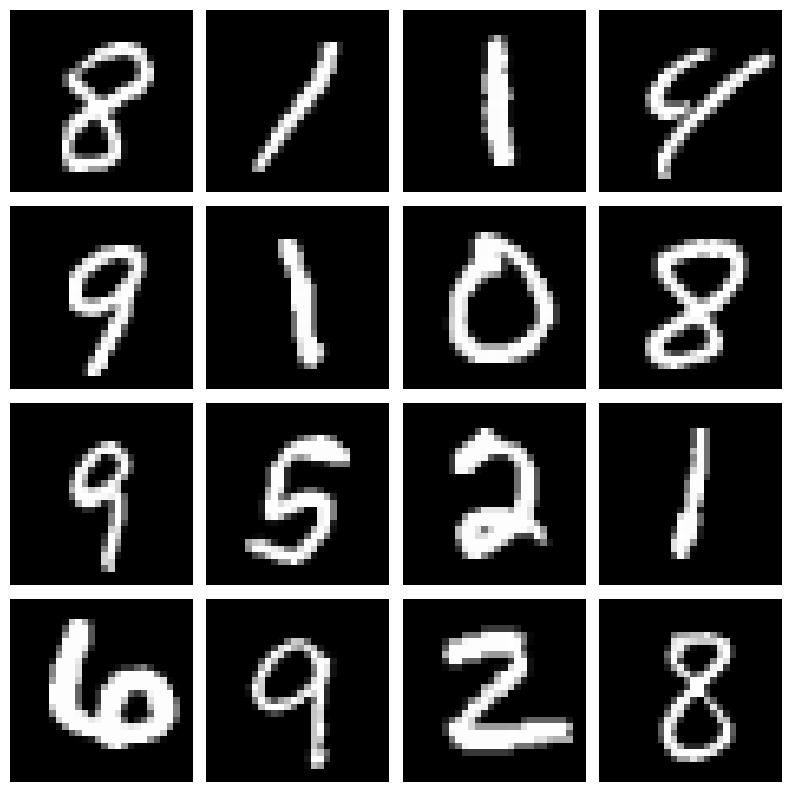

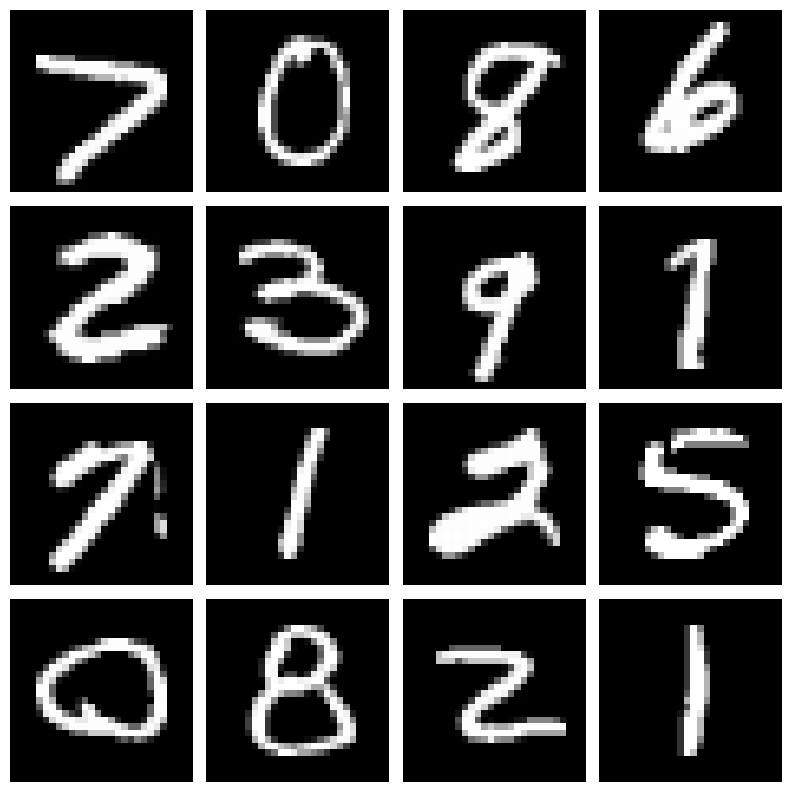

In [5]:
if DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))


elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=1000, max_classes=10, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="mse",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-3
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['resnet']['encoder'](model_config),
#     decoder=architecture_dict['resnet']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 56 µs, sys: 33 µs, total: 89 µs
Wall time: 92.5 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=500,
    learning_rate=1e-4,
    per_device_train_batch_size=1000, #len(train_dataset),
    per_device_eval_batch_size=1000, #len(eval_dataset),
    no_cuda=False,
    scheduler_cls="MultiStepLR",
    scheduler_params={
            "milestones": [200, 350, 500, 750, 1000],
            "gamma": 10 ** (-1 / 5),
            "verbose": True,
        },
    # optimizer_cls="AdamW",
    # optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    # scheduler_cls="ReduceLROnPlateau",
    # scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer



Adjusting learning rate of group 0 to 1.0000e-04.


Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-05-29_15-41-52. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 1000
 - per_device_eval_batch_size: 1000
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.MultiStepLR object at 0x7fdd967864a0>

Successfully launched training !



Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 1/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 1/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11461468.5272
Eval loss: 81.7421
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 2/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 2/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.2766
Eval loss: 76.8039
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 3/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 3/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.2232
Eval loss: 71.8909
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 4/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 4/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.9163
Eval loss: 67.4104
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 5/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 5/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.8612
Eval loss: 63.1894
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 6/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 6/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.0873
Eval loss: 59.1978
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 7/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 7/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.8146
Eval loss: 55.3897
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 8/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 8/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.0491
Eval loss: 52.1365
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 9/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 9/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.6329
Eval loss: 49.0139
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 10/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 10/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.5061
Eval loss: 46.2632
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 11/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 11/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.0788
Eval loss: 44.209
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 12/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 12/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.8538
Eval loss: 41.9544
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 13/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 13/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.9143
Eval loss: 40.2725
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 14/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 14/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.3764
Eval loss: 38.5148
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 15/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 15/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.9265
Eval loss: 37.0164
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 16/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 16/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.4332
Eval loss: 35.6027
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 17/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 17/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.1716
Eval loss: 34.5588
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 18/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 18/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.1078
Eval loss: 33.646
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 19/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 19/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.31
Eval loss: 32.4799
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 20/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 20/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.7116
Eval loss: 32.0761
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 21/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 21/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.0984
Eval loss: 31.3354
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 22/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 22/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.5991
Eval loss: 30.6187
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 23/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 23/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.119
Eval loss: 30.2725
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 24/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 24/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.7001
Eval loss: 30.0451
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 25/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 25/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.3192
Eval loss: 29.8137
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 26/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 26/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.033
Eval loss: 29.3438
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 27/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 27/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.7131
Eval loss: 29.0741
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 28/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 28/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.4272
Eval loss: 28.881
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 29/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 29/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.2195
Eval loss: 28.7156
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 30/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 30/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.9679
Eval loss: 28.4903
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 31/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 31/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.7602
Eval loss: 28.2322
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 32/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 32/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.6035
Eval loss: 28.1543
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 33/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 33/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.4586
Eval loss: 27.9068
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 34/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 34/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.3162
Eval loss: 27.7084
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 35/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 35/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.1209
Eval loss: 27.7049
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 36/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 36/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.976
Eval loss: 27.5401
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 37/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 37/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.8268
Eval loss: 27.3858
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 38/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 38/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.7535
Eval loss: 27.3162
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 39/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 39/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.6112
Eval loss: 27.1841
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 40/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 40/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.4783
Eval loss: 27.0962
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 41/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 41/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.3826
Eval loss: 26.8944
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 42/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 42/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.2802
Eval loss: 26.8611
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 43/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 43/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.1717
Eval loss: 26.7285
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 44/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 44/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.0919
Eval loss: 26.7054
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 45/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 45/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.9777
Eval loss: 26.6069
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 46/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 46/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.9221
Eval loss: 26.4971
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 47/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 47/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.8372
Eval loss: 26.3879
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 48/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 48/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.7268
Eval loss: 26.3481
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 49/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 49/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.6542
Eval loss: 26.2493
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 50/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 50/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.6111
Eval loss: 26.2645
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 51/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 51/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.5333
Eval loss: 26.138
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 52/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 52/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.4759
Eval loss: 26.0419
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 53/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 53/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.3423
Eval loss: 26.0386
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 54/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 54/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.3093
Eval loss: 25.9081
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 55/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 55/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.2315
Eval loss: 25.9155
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 56/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 56/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.1623
Eval loss: 25.7259
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 57/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 57/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.088
Eval loss: 25.6905
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 58/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 58/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.0215
Eval loss: 25.6493
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 59/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 59/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.9345
Eval loss: 25.575
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 60/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 60/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.8434
Eval loss: 25.5456
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 61/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 61/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.7746
Eval loss: 25.4074
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 62/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 62/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.6894
Eval loss: 25.3752
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 63/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 63/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.6021
Eval loss: 25.2839
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 64/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 64/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.4919
Eval loss: 25.1362
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 65/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 65/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.4227
Eval loss: 25.0429
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 66/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 66/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.3008
Eval loss: 24.9739
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 67/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 67/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.237
Eval loss: 24.9375
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 68/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 68/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.1379
Eval loss: 24.8042
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 69/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 69/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.1011
Eval loss: 24.7817
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 70/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 70/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.016
Eval loss: 24.7393
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 71/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 71/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.9267
Eval loss: 24.5956
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 72/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 72/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.8754
Eval loss: 24.5289
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 73/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 73/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.7953
Eval loss: 24.5042
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 74/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 74/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.7902
Eval loss: 24.4244
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 75/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 75/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.7293
Eval loss: 24.3896
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 76/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 76/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.6827
Eval loss: 24.3599
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 77/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 77/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.6307
Eval loss: 24.3261
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 78/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 78/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.5884
Eval loss: 24.3387
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 79/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 79/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.5646
Eval loss: 24.2615
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 80/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 80/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.5302
Eval loss: 24.1726
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 81/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 81/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.4794
Eval loss: 24.1662
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 82/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 82/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.4613
Eval loss: 24.0967
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 83/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 83/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.4074
Eval loss: 24.1445
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 84/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 84/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.3737
Eval loss: 24.0971
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 85/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 85/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.3629
Eval loss: 24.0043
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 86/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 86/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.3183
Eval loss: 24.0487
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 87/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 87/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.286
Eval loss: 23.9805
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 88/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 88/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.2673
Eval loss: 23.9815
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 89/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 89/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.2308
Eval loss: 23.916
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 90/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 90/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.1981
Eval loss: 23.8888
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 91/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 91/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.1874
Eval loss: 23.8911
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 92/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 92/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.1574
Eval loss: 23.851
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 93/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 93/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.1168
Eval loss: 23.807
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 94/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 94/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.128
Eval loss: 23.7603
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 95/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 95/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.0935
Eval loss: 23.7602
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 96/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 96/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.0534
Eval loss: 23.7655
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 97/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 97/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.0283
Eval loss: 23.7145
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 98/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 98/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.0342
Eval loss: 23.6898
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 99/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 99/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.01
Eval loss: 23.6609
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 100/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 100/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.9701
Eval loss: 23.648
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 101/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 101/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.9504
Eval loss: 23.6282
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 102/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 102/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.9021
Eval loss: 23.609
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 103/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 103/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.9299
Eval loss: 23.5556
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 104/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 104/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.8805
Eval loss: 23.6014
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 105/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 105/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.857
Eval loss: 23.5675
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 106/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 106/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.8508
Eval loss: 23.5764
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 107/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 107/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.8181
Eval loss: 23.5453
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 108/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 108/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.806
Eval loss: 23.4909
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 109/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 109/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.8029
Eval loss: 23.4583
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 110/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 110/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.7802
Eval loss: 23.5045
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 111/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 111/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.735
Eval loss: 23.4402
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 112/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 112/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.7394
Eval loss: 23.3948
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 113/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 113/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.7204
Eval loss: 23.4294
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 114/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 114/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.7011
Eval loss: 23.3719
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 115/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 115/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.6669
Eval loss: 23.4348
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 116/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 116/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.6585
Eval loss: 23.3277
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 117/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 117/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.6356
Eval loss: 23.3647
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 118/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 118/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.6292
Eval loss: 23.3201
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 119/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 119/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.6039
Eval loss: 23.2954
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 120/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 120/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.5889
Eval loss: 23.3351
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 121/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 121/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.548
Eval loss: 23.2226
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 122/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 122/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.5637
Eval loss: 23.2342
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 123/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 123/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.5325
Eval loss: 23.2294
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 124/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 124/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.5167
Eval loss: 23.2663
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 125/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 125/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.509
Eval loss: 23.1867
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 126/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 126/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4841
Eval loss: 23.233
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 127/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 127/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4575
Eval loss: 23.1736
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 128/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 128/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4544
Eval loss: 23.1539
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 129/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 129/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4303
Eval loss: 23.1676
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 130/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 130/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4101
Eval loss: 23.1461
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 131/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 131/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.3791
Eval loss: 23.1214
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 132/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 132/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.3718
Eval loss: 23.0679
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 133/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 133/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.3803
Eval loss: 23.0772
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 134/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 134/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.3663
Eval loss: 23.0777
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 135/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 135/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.349
Eval loss: 22.9906
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 136/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 136/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.3423
Eval loss: 23.0648
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 137/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 137/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.3022
Eval loss: 23.0069
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 138/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 138/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.307
Eval loss: 23.0018
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 139/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 139/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2664
Eval loss: 23.0481
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 140/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 140/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2966
Eval loss: 22.9777
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 141/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 141/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2635
Eval loss: 22.9334
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 142/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 142/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2268
Eval loss: 22.9351
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 143/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 143/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2247
Eval loss: 22.9565
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 144/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 144/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2109
Eval loss: 22.8615
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 145/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 145/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2116
Eval loss: 22.9363
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 146/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 146/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.1961
Eval loss: 22.9116
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 147/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 147/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.1548
Eval loss: 22.8519
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 148/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 148/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.1505
Eval loss: 22.8418
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 149/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 149/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.141
Eval loss: 22.8406
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 150/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 150/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.1342
Eval loss: 22.8849
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 151/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 151/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.1028
Eval loss: 22.8088
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 152/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 152/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.1027
Eval loss: 22.7398
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 153/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 153/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0881
Eval loss: 22.7467
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 154/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 154/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0721
Eval loss: 22.7758
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 155/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 155/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0734
Eval loss: 22.7695
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 156/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 156/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0245
Eval loss: 22.702
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 157/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 157/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0191
Eval loss: 22.667
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 158/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 158/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0165
Eval loss: 22.6829
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 159/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 159/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0137
Eval loss: 22.6949
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 160/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 160/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9908
Eval loss: 22.6954
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 161/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 161/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9712
Eval loss: 22.6504
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 162/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 162/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9851
Eval loss: 22.6504
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 163/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 163/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.956
Eval loss: 22.7089
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 164/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 164/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9385
Eval loss: 22.6934
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 165/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 165/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9316
Eval loss: 22.6911
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 166/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 166/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9175
Eval loss: 22.6298
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 167/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 167/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9249
Eval loss: 22.6158
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 168/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 168/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8786
Eval loss: 22.5465
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 169/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 169/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8614
Eval loss: 22.5535
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 170/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 170/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8433
Eval loss: 22.5617
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 171/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 171/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8405
Eval loss: 22.54
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 172/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 172/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8
Eval loss: 22.5746
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 173/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 173/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8122
Eval loss: 22.5264
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 174/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 174/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7931
Eval loss: 22.5669
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 175/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 175/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7765
Eval loss: 22.5013
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 176/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 176/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7706
Eval loss: 22.4608
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 177/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 177/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7617
Eval loss: 22.4428
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 178/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 178/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7528
Eval loss: 22.4677
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 179/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 179/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7504
Eval loss: 22.4308
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 180/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 180/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7138
Eval loss: 22.491
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 181/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 181/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7129
Eval loss: 22.4178
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 182/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 182/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6819
Eval loss: 22.3552
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 183/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 183/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6683
Eval loss: 22.3262
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 184/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 184/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6676
Eval loss: 22.3779
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 185/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 185/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6689
Eval loss: 22.3897
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 186/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 186/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.654
Eval loss: 22.3915
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 187/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 187/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6259
Eval loss: 22.337
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 188/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 188/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6163
Eval loss: 22.3011
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 189/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 189/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6008
Eval loss: 22.3107
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 190/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 190/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5893
Eval loss: 22.2918
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 191/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 191/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5809
Eval loss: 22.3442
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 192/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 192/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5531
Eval loss: 22.2647
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 193/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 193/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5506
Eval loss: 22.2598
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 194/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 194/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5146
Eval loss: 22.1867
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 195/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 195/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5385
Eval loss: 22.3047
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 196/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 196/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4983
Eval loss: 22.2555
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 197/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 197/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.485
Eval loss: 22.2017
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 198/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 198/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4954
Eval loss: 22.1951
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 199/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 199/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4606
Eval loss: 22.1722
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-04.


Training of epoch 200/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 200/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4565
Eval loss: 22.188
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 201/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 201/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4437
Eval loss: 22.1873
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 202/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 202/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4345
Eval loss: 22.1363
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 203/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 203/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4088
Eval loss: 22.0686
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 204/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 204/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.435
Eval loss: 22.1171
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 205/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 205/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4019
Eval loss: 22.1382
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 206/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 206/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4041
Eval loss: 22.0818
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 207/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 207/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4017
Eval loss: 22.1631
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 208/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 208/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4154
Eval loss: 22.0868
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 209/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 209/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3886
Eval loss: 22.1029
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 210/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 210/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.372
Eval loss: 22.0629
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 211/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 211/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3585
Eval loss: 22.1229
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 212/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 212/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3548
Eval loss: 22.079
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 213/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 213/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3541
Eval loss: 22.0068
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 214/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 214/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3412
Eval loss: 22.0531
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 215/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 215/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3441
Eval loss: 22.0669
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 216/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 216/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3318
Eval loss: 22.0361
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 217/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 217/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.325
Eval loss: 22.015
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 218/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 218/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3044
Eval loss: 22.0579
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 219/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 219/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3126
Eval loss: 22.0377
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 220/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 220/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3056
Eval loss: 21.99
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 221/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 221/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2888
Eval loss: 21.965
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 222/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 222/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3015
Eval loss: 22.0503
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 223/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 223/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.265
Eval loss: 22.0186
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 224/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 224/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2672
Eval loss: 21.9614
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 225/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 225/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2758
Eval loss: 21.9622
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 226/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 226/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2536
Eval loss: 21.9397
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 227/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 227/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2428
Eval loss: 21.9299
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 228/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 228/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2439
Eval loss: 21.9326
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 229/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 229/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2093
Eval loss: 21.9819
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 230/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 230/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2276
Eval loss: 21.9434
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 231/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 231/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2151
Eval loss: 21.8552
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 232/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 232/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1995
Eval loss: 21.9023
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 233/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 233/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2053
Eval loss: 21.892
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 234/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 234/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1953
Eval loss: 21.8917
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 235/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 235/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1721
Eval loss: 21.8819
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 236/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 236/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1804
Eval loss: 21.9093
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 237/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 237/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1455
Eval loss: 21.8616
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 238/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 238/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1343
Eval loss: 21.8392
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 239/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 239/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1432
Eval loss: 21.8841
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 240/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 240/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1489
Eval loss: 21.8224
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 241/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 241/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1261
Eval loss: 21.8369
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 242/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 242/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.106
Eval loss: 21.8163
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 243/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 243/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1495
Eval loss: 21.8279
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 244/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 244/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0891
Eval loss: 21.8385
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 245/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 245/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1031
Eval loss: 21.8395
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 246/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 246/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0759
Eval loss: 21.7866
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 247/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 247/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0764
Eval loss: 21.8682
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 248/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 248/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0837
Eval loss: 21.7286
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 249/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 249/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0599
Eval loss: 21.7582
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 250/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 250/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.04
Eval loss: 21.7139
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 251/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 251/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0469
Eval loss: 21.7455
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 252/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 252/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0355
Eval loss: 21.7691
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 253/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 253/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0123
Eval loss: 21.7137
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 254/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 254/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0317
Eval loss: 21.6938
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 255/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 255/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0087
Eval loss: 21.7377
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 256/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 256/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9949
Eval loss: 21.6763
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 257/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 257/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0128
Eval loss: 21.739
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 258/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 258/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9843
Eval loss: 21.6693
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 259/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 259/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.985
Eval loss: 21.6255
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 260/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 260/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9575
Eval loss: 21.6578
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 261/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 261/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9766
Eval loss: 21.6492
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 262/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 262/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9601
Eval loss: 21.6325
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 263/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 263/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9483
Eval loss: 21.6676
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 264/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 264/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9578
Eval loss: 21.6249
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 265/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 265/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9323
Eval loss: 21.6298
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 266/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 266/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9279
Eval loss: 21.6142
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 267/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 267/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9325
Eval loss: 21.6074
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 268/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 268/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.9218
Eval loss: 21.5742
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 269/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 269/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8791
Eval loss: 21.5694
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 270/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 270/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8857
Eval loss: 21.5736
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 271/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 271/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8749
Eval loss: 21.5851
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 272/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 272/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8595
Eval loss: 21.5245
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 273/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 273/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8859
Eval loss: 21.5758
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 274/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 274/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8524
Eval loss: 21.5415
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 275/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 275/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.852
Eval loss: 21.5711
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 276/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 276/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8344
Eval loss: 21.4714
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 277/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 277/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8291
Eval loss: 21.5375
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 278/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 278/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8575
Eval loss: 21.5047
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 279/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 279/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.826
Eval loss: 21.4833
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 280/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 280/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7956
Eval loss: 21.5118
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 281/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 281/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.8125
Eval loss: 21.4665
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 282/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 282/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7903
Eval loss: 21.531
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 283/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 283/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7821
Eval loss: 21.4725
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 284/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 284/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7685
Eval loss: 21.4364
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 285/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 285/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.739
Eval loss: 21.441
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 286/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 286/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7605
Eval loss: 21.4365
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 287/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 287/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7407
Eval loss: 21.4478
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 288/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 288/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7365
Eval loss: 21.4755
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 289/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 289/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7291
Eval loss: 21.4201
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 290/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 290/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.7155
Eval loss: 21.4112
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 291/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 291/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.684
Eval loss: 21.4037
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 292/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 292/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6862
Eval loss: 21.3821
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 293/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 293/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6944
Eval loss: 21.2997
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 294/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 294/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6693
Eval loss: 21.4106
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 295/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 295/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6509
Eval loss: 21.2802
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 296/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 296/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6652
Eval loss: 21.327
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 297/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 297/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6544
Eval loss: 21.3437
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 298/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 298/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6292
Eval loss: 21.2388
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 299/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 299/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.591
Eval loss: 21.2979
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 300/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 300/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6364
Eval loss: 21.2519
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 301/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 301/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6156
Eval loss: 21.2853
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 302/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 302/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.6156
Eval loss: 21.2619
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 303/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 303/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5982
Eval loss: 21.2679
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 304/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 304/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5783
Eval loss: 21.2552
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 305/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 305/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5832
Eval loss: 21.2602
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 306/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 306/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5485
Eval loss: 21.1978
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 307/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 307/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5536
Eval loss: 21.1444
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 308/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 308/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5332
Eval loss: 21.1872
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 309/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 309/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5499
Eval loss: 21.1933
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 310/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 310/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5195
Eval loss: 21.2121
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 311/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 311/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.5061
Eval loss: 21.1978
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 312/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 312/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4846
Eval loss: 21.1916
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 313/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 313/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.486
Eval loss: 21.1902
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 314/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 314/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4985
Eval loss: 21.2024
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 315/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 315/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4668
Eval loss: 21.166
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 316/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 316/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.467
Eval loss: 21.1592
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 317/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 317/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4679
Eval loss: 21.0886
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 318/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 318/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4817
Eval loss: 21.1473
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 319/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 319/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4521
Eval loss: 21.0863
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 320/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 320/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4406
Eval loss: 21.1208
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 321/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 321/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4204
Eval loss: 21.143
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 322/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 322/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4173
Eval loss: 21.1096
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 323/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 323/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3934
Eval loss: 21.0965
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 324/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 324/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.4254
Eval loss: 21.0604
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 325/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 325/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3771
Eval loss: 21.0331
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 326/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 326/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3618
Eval loss: 21.0513
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 327/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 327/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3919
Eval loss: 21.0103
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 328/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 328/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3569
Eval loss: 21.0373
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 329/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 329/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3462
Eval loss: 20.9868
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 330/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 330/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3478
Eval loss: 21.0325
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 331/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 331/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3232
Eval loss: 21.0653
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 332/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 332/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3178
Eval loss: 20.984
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 333/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 333/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3128
Eval loss: 20.9947
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 334/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 334/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.3075
Eval loss: 20.9272
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 335/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 335/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2789
Eval loss: 20.9671
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 336/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 336/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2625
Eval loss: 20.9057
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 337/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 337/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2785
Eval loss: 20.921
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 338/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 338/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2764
Eval loss: 20.8727
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 339/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 339/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.248
Eval loss: 20.9268
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 340/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 340/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2505
Eval loss: 20.8987
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 341/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 341/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2427
Eval loss: 20.9045
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 342/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 342/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2329
Eval loss: 20.8863
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 343/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 343/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2267
Eval loss: 20.8449
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 344/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 344/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1911
Eval loss: 20.8221
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 345/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 345/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.2306
Eval loss: 20.8869
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 346/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 346/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1891
Eval loss: 20.8553
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 347/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 347/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1623
Eval loss: 20.8985
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 348/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 348/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1815
Eval loss: 20.7872
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 349/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 349/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1924
Eval loss: 20.8628
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 6.3096e-05.


Training of epoch 350/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 350/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1806
Eval loss: 20.8349
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 351/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 351/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1717
Eval loss: 20.8493
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 352/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 352/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1498
Eval loss: 20.8524
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 353/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 353/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1629
Eval loss: 20.8861
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 354/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 354/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1456
Eval loss: 20.7744
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 355/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 355/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1377
Eval loss: 20.796
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 356/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 356/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1274
Eval loss: 20.7952
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 357/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 357/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1267
Eval loss: 20.7869
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 358/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 358/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1333
Eval loss: 20.8626
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 359/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 359/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1181
Eval loss: 20.8026
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 360/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 360/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1055
Eval loss: 20.783
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 361/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 361/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.105
Eval loss: 20.7456
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 362/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 362/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1027
Eval loss: 20.7203
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 363/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 363/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0938
Eval loss: 20.7659
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 364/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 364/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.123
Eval loss: 20.7428
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 365/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 365/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.11
Eval loss: 20.7506
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 366/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 366/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0829
Eval loss: 20.7866
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 367/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 367/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0865
Eval loss: 20.75
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 368/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 368/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0875
Eval loss: 20.7179
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 369/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 369/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0677
Eval loss: 20.7173
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 370/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 370/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0765
Eval loss: 20.7182
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 371/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 371/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0626
Eval loss: 20.7298
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 372/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 372/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0743
Eval loss: 20.7474
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 373/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 373/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0492
Eval loss: 20.7735
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 374/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 374/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0579
Eval loss: 20.7342
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 375/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 375/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0604
Eval loss: 20.6899
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 376/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 376/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0325
Eval loss: 20.7076
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 377/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 377/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0415
Eval loss: 20.6993
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 378/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 378/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0239
Eval loss: 20.6898
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 379/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 379/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0497
Eval loss: 20.6892
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 380/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 380/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0267
Eval loss: 20.6818
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 381/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 381/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0188
Eval loss: 20.6844
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 382/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 382/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0138
Eval loss: 20.6703
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 383/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 383/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.0198
Eval loss: 20.6906
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 384/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 384/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9968
Eval loss: 20.7151
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 385/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 385/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9912
Eval loss: 20.6152
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 386/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 386/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9829
Eval loss: 20.708
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 387/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 387/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9738
Eval loss: 20.6217
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 388/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 388/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9794
Eval loss: 20.6615
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 389/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 389/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9587
Eval loss: 20.7079
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 390/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 390/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9616
Eval loss: 20.6793
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 391/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 391/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9606
Eval loss: 20.6436
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 392/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 392/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.974
Eval loss: 20.6277
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 393/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 393/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9595
Eval loss: 20.6368
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 394/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 394/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9602
Eval loss: 20.5747
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 395/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 395/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.948
Eval loss: 20.6426
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 396/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 396/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9216
Eval loss: 20.6607
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 397/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 397/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9372
Eval loss: 20.5808
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 398/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 398/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9415
Eval loss: 20.5728
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 399/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 399/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9295
Eval loss: 20.5632
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 400/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 400/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9235
Eval loss: 20.5833
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 401/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 401/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9178
Eval loss: 20.5865
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 402/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 402/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9089
Eval loss: 20.6
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 403/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 403/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9178
Eval loss: 20.5649
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 404/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 404/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9188
Eval loss: 20.6231
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 405/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 405/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9168
Eval loss: 20.5973
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 406/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 406/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9017
Eval loss: 20.6151
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 407/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 407/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9209
Eval loss: 20.5186
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 408/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 408/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9028
Eval loss: 20.5511
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 409/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 409/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8957
Eval loss: 20.5588
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 410/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 410/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8648
Eval loss: 20.5078
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 411/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 411/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9024
Eval loss: 20.5584
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 412/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 412/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.884
Eval loss: 20.5515
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 413/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 413/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8595
Eval loss: 20.57
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 414/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 414/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8877
Eval loss: 20.5317
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 415/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 415/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8723
Eval loss: 20.5284
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 416/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 416/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8652
Eval loss: 20.4956
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 417/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 417/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8424
Eval loss: 20.4939
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 418/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 418/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8486
Eval loss: 20.4969
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 419/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 419/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8435
Eval loss: 20.5972
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 420/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 420/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8559
Eval loss: 20.475
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 421/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 421/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8449
Eval loss: 20.4726
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 422/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 422/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8345
Eval loss: 20.5292
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 423/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 423/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8356
Eval loss: 20.4526
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 424/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 424/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8265
Eval loss: 20.563
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 425/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 425/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.821
Eval loss: 20.4701
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 426/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 426/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8144
Eval loss: 20.4766
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 427/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 427/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8401
Eval loss: 20.5034
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 428/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 428/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8287
Eval loss: 20.4915
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 429/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 429/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8267
Eval loss: 20.5201
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 430/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 430/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8076
Eval loss: 20.5263
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 431/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 431/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8381
Eval loss: 20.4764
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 432/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 432/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7933
Eval loss: 20.4685
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 433/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 433/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.8147
Eval loss: 20.469
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 434/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 434/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7775
Eval loss: 20.4471
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 435/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 435/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7838
Eval loss: 20.4696
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 436/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 436/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7837
Eval loss: 20.5085
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 437/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 437/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7548
Eval loss: 20.453
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 438/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 438/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.757
Eval loss: 20.4531
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 439/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 439/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7785
Eval loss: 20.4041
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 440/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 440/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7636
Eval loss: 20.4837
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 441/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 441/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.76
Eval loss: 20.486
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 442/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 442/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7496
Eval loss: 20.4902
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 443/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 443/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7632
Eval loss: 20.4676
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 444/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 444/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7545
Eval loss: 20.4076
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 445/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 445/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7666
Eval loss: 20.3942
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 446/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 446/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7334
Eval loss: 20.4547
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 447/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 447/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7321
Eval loss: 20.3787
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 448/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 448/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7619
Eval loss: 20.4307
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 449/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 449/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7161
Eval loss: 20.4295
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 450/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 450/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7303
Eval loss: 20.3303
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 451/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 451/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7361
Eval loss: 20.4111
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 452/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 452/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7278
Eval loss: 20.4235
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 453/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 453/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7203
Eval loss: 20.4543
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 454/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 454/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7194
Eval loss: 20.4684
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 455/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 455/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6999
Eval loss: 20.4036
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 456/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 456/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7311
Eval loss: 20.3774
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 457/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 457/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7115
Eval loss: 20.4204
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 458/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 458/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7134
Eval loss: 20.4058
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 459/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 459/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.7019
Eval loss: 20.4039
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 460/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 460/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.678
Eval loss: 20.3976
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 461/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 461/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.695
Eval loss: 20.3699
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 462/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 462/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6975
Eval loss: 20.3735
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 463/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 463/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6966
Eval loss: 20.3952
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 464/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 464/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.68
Eval loss: 20.4099
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 465/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 465/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6638
Eval loss: 20.3379
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 466/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 466/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6836
Eval loss: 20.3357
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 467/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 467/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6729
Eval loss: 20.369
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 468/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 468/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6778
Eval loss: 20.3966
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 469/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 469/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6893
Eval loss: 20.3483
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 470/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 470/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6722
Eval loss: 20.3512
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 471/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 471/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6703
Eval loss: 20.3306
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 472/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 472/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.676
Eval loss: 20.3541
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 473/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 473/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.66
Eval loss: 20.3169
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 474/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 474/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6533
Eval loss: 20.322
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 475/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 475/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6494
Eval loss: 20.3452
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 476/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 476/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6496
Eval loss: 20.3017
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 477/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 477/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6286
Eval loss: 20.3242
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 478/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 478/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6559
Eval loss: 20.3274
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 479/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 479/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6346
Eval loss: 20.2767
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 480/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 480/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6382
Eval loss: 20.3007
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 481/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 481/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6421
Eval loss: 20.273
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 482/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 482/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6319
Eval loss: 20.2785
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 483/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 483/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6188
Eval loss: 20.2746
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 484/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 484/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6377
Eval loss: 20.2743
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 485/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 485/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6092
Eval loss: 20.3542
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 486/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 486/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6493
Eval loss: 20.2435
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 487/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 487/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5861
Eval loss: 20.2723
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 488/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 488/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.618
Eval loss: 20.3292
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 489/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 489/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.616
Eval loss: 20.3102
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 490/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 490/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6094
Eval loss: 20.3079
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 491/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 491/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5934
Eval loss: 20.2947
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 492/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 492/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5887
Eval loss: 20.2297
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 493/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 493/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6065
Eval loss: 20.2687
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 494/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 494/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5762
Eval loss: 20.2591
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 495/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 495/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5882
Eval loss: 20.2441
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 496/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 496/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5776
Eval loss: 20.3129
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 497/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 497/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5953
Eval loss: 20.2649
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 498/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 498/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5634
Eval loss: 20.2378
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 499/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 499/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5849
Eval loss: 20.2124
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 3.9811e-05.


Training of epoch 500/500:   0%|          | 0/8 [00:00<?, ?batch/s]

Eval of epoch 500/500:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5699
Eval loss: 20.2812
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-05-29_15-41-52/final_model


Adjusting learning rate of group 0 to 2.5119e-05.
CPU times: user 9min 25s, sys: 46.1 s, total: 10min 11s
Wall time: 10min 8s


## Trained Model

In [12]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# RECONSTRUCTIONS

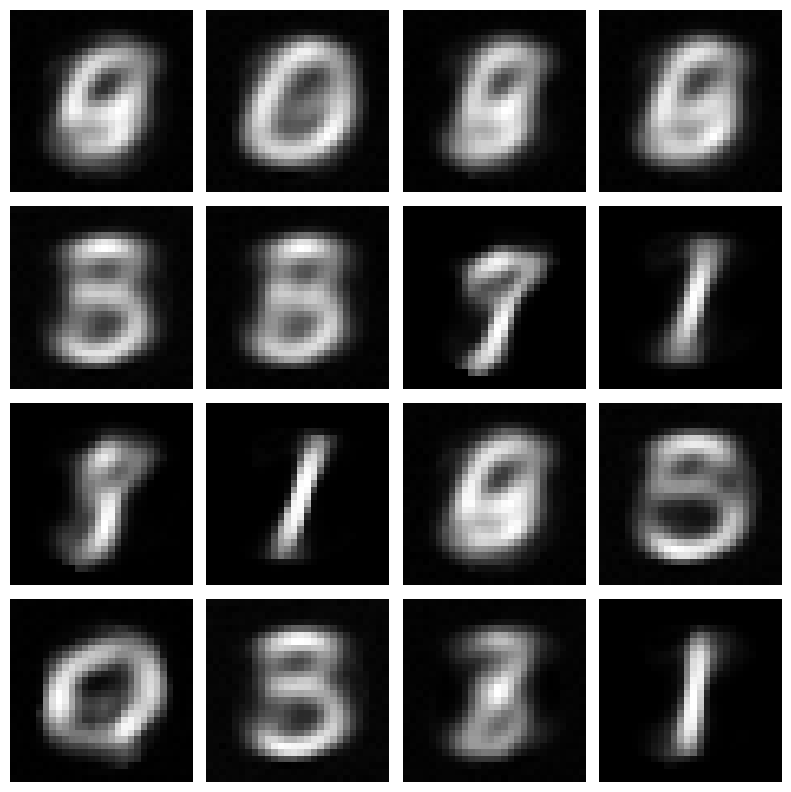

In [14]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

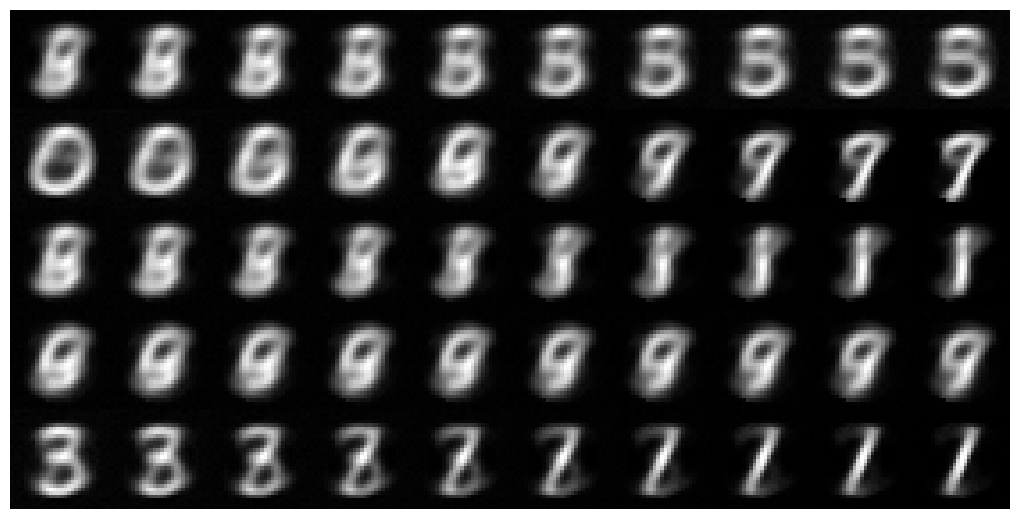

In [15]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [16]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, 28, 28)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


/home/dmandach/miniconda3/envs/py310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## Generators

### Normal Sampler

In [17]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

FID = 0.7589
IS [mean] = 1.4220
IS [std] = 0.3171


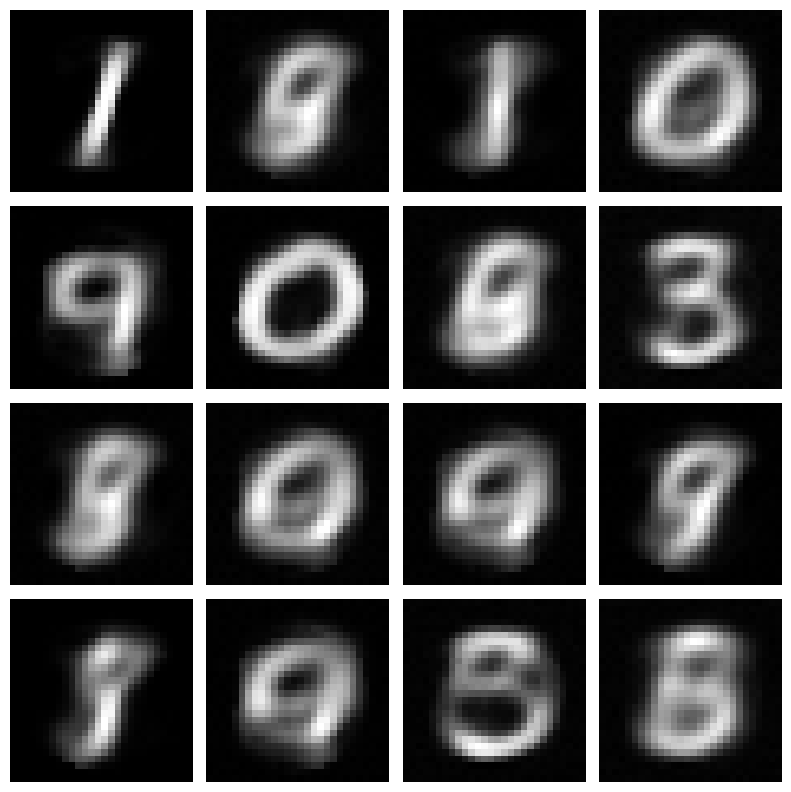

In [18]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [19]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

FID = 0.6727
IS [mean] = 1.8247
IS [std] = 0.1804


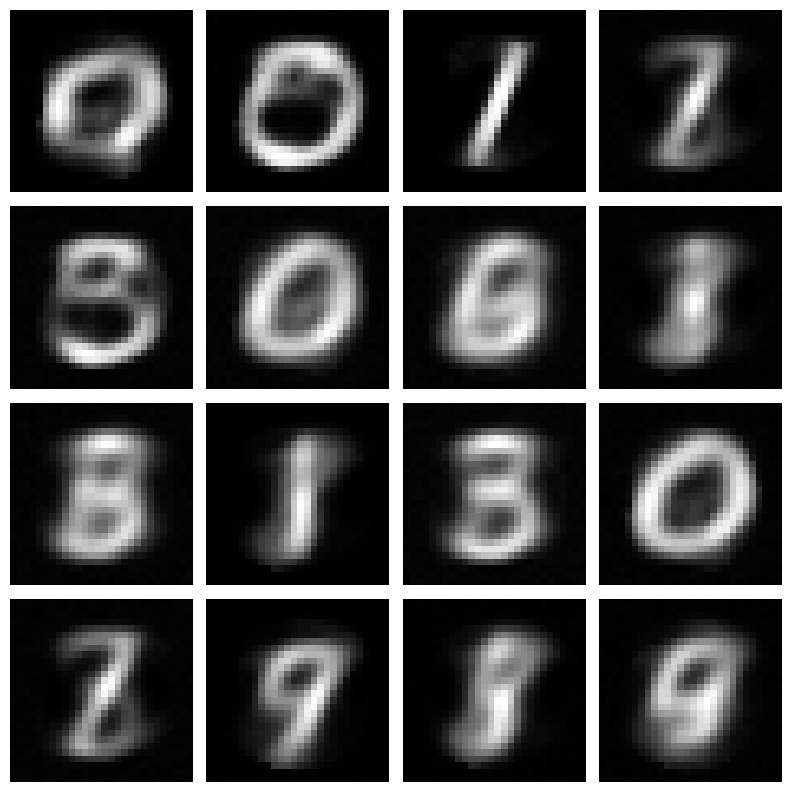

In [20]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [21]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    # mcmc_steps_nbr = 200,
    # n_lf = 3,
    # eps_lf = 1e-3,
    # beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

FID = 0.6058
IS [mean] = 2.0264
IS [std] = 0.1707


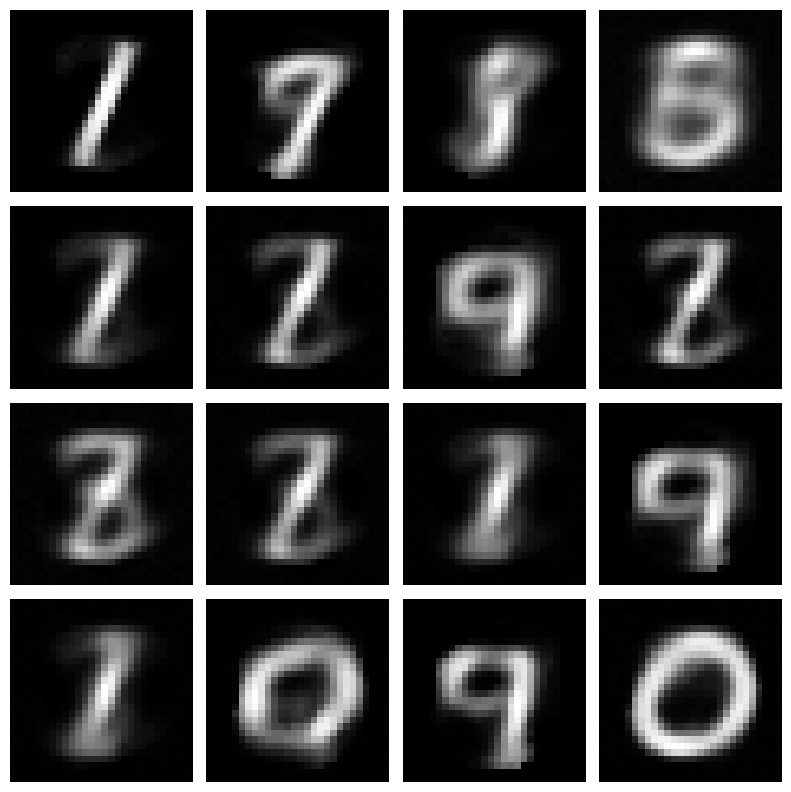

In [22]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)